## Introduction
In this notebook you will download and preprocess the data for the segmentation task for cardiac mri images:<br />
The data is provided by the medical segmentation decathlon (http://medicaldecathlon.com/)<br /> (Data License: https://creativecommons.org/licenses/by-sa/4.0/)<br />

You can directly download the cardiac MRIs and segmentation maps from: <br />
https://drive.google.com/file/d/1wEB2I6S6tQBVEPxir8cA5kFB8gTQadYY/view?usp=sharing

## Imports:
* Pathlib for easy path handling
* nibabel as the files are provided in the NIfTI format
* numpy for data saving and processing
* matplotlib for plotting
* tqdm for nice progressing bars

In [9]:
import os
import sys
for p in sys.path:
    print(p)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm 
import nibabel as nib

/Users/marcusc/Desktop/MyRepos/AtriumSegmentation_Pytorch
/Users/marcusc/Desktop/MyRepos/AtriumSegmentation_Pytorch/pytorchatrium/lib/python38.zip
/Users/marcusc/Desktop/MyRepos/AtriumSegmentation_Pytorch/pytorchatrium/lib/python3.8
/Users/marcusc/Desktop/MyRepos/AtriumSegmentation_Pytorch/pytorchatrium/lib/python3.8/lib-dynload

/Users/marcusc/Desktop/MyRepos/AtriumSegmentation_Pytorch/pytorchatrium/lib/python3.8/site-packages


In [1]:
# %matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Inspection:
Let's first inspect some sample data

In [2]:
root = Path("Task02_Heart/imagesTr/")
label = Path("Task02_Heart/labelsTr/")

We start with a helper function which automatically replaces "imagesTr" with "labelsTr" in the filepaths so that we can easily switch between mri images and label masks

In [3]:
# Testing certain functions
print(f"root \t: {root}")
sample_path = list(root.glob("la*"))[0]
print(f"sample_path \t: {sample_path}")
print(f"sample_path.parts \t: {sample_path.parts}")
parts = list(sample_path.parts)
parts[parts.index("imagesTr")] = "labelsTr"
print(f"parts \t: {sample_path.parts}")
print(f"Path(*parts) \t: {Path(*parts)}")
# Path(*sample_path.parts)

root 	: Task02_Heart/imagesTr
sample_path 	: Task02_Heart/imagesTr/la_007.nii.gz
sample_path.parts 	: ('Task02_Heart', 'imagesTr', 'la_007.nii.gz')
parts 	: ('Task02_Heart', 'imagesTr', 'la_007.nii.gz')
Path(*parts) 	: Task02_Heart/labelsTr/la_007.nii.gz


In [4]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


Notes:
la* because all files start with la which stands for long axis

In [5]:
sample_path = list(root.glob("la*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [6]:
sample_path, sample_path_label

(PosixPath('Task02_Heart/imagesTr/la_007.nii.gz'),
 PosixPath('Task02_Heart/labelsTr/la_007.nii.gz'))

Load NIfTI and extract image data

In [7]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)  # Class labels should not be handled as float64

In [8]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

Let's inspect the data.
We use the sagittal view for this task as it provides the "nicest" images<br />

We can use celluloid (https://github.com/jwkvam/celluloid) which is a great tool for live visualization in matplotlib.<br />
Additionally we import HTML from IPython.display to create a video of the volume.

### **Note that %matplotlib notebook is necessary**

In [9]:
from celluloid import Camera
from IPython.display import HTML
%matplotlib notebook

<IPython.core.display.Javascript object>


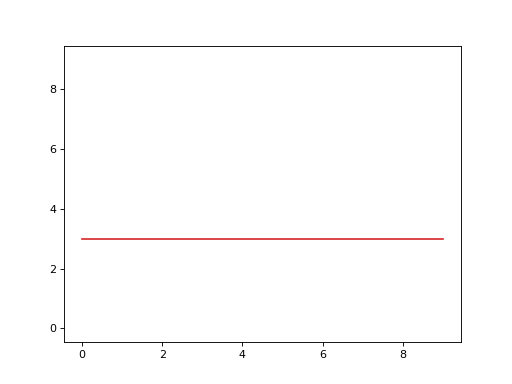

In [16]:
# %matplotlib notebook
# fig = plt.figure()
# camera = Camera(fig)
# for i in range(10):
#     plt.plot([i] * 10)
#     camera.snap()
# animation = camera.animate()

<IPython.core.display.Javascript object>


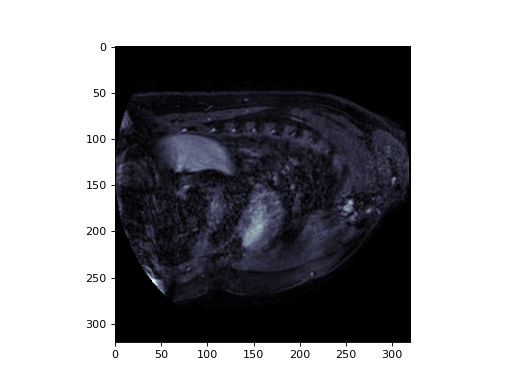

In [17]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    # plt.axis("off")
#     plt.show()
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation




In [19]:
# HTML(animation.to_html5_video())  # convert the animation to a video


## Preprocessing
We perform the following preprocessing steps:

1. Normalization per subject. We compute mean and sigma of the full 3d volume $X$ and then perform z-normalization:
$$X_n = \frac{X-\mu}{\sigma}$$
2. There is a plenty of empty space around the image, so we can crop the image (e.g 32 px from top and bottom). Additionally, we can crop away non-cardiac regions as they will definitely not contain the left atrium. This will  reduce training time due to the smaller size and will simplify the segmentation. It is important to crop first and to normalize afterwards. Otherwise the included zero values introduce skewness to the intesity distribution.
3. Standardize the normalized subject into the 0-1 range:
$$X_s = \frac{X_n - min(X_n)}{max(X_n)-min(X_n)} $$
4. This task will be performed on a slice level (2D) and not on a subject level (3D). In order to reduce the computational cost we store the preprocessed data as npy files of 2d slices. Reading a single slice is much faster than loading the complete NIfTI file every time.

In [20]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


In [21]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

Now we can loop over the subjects and store the preprocessed files in the corresponding directories.
To evaluate our model we use the last 4 subjects as validation set.

We want to create a directory containing a numpy file for each slice of the MRI image and the associated label mask of each subject.
E.g:
* 0/data/0.npy
* 0/masks/0.npy

In [22]:
all_files = list(root.glob("la*"))  # Get all subjects
len(all_files)

20

In [23]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")    
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
    # Addtionally crop front and back with same size. Dont crop viewing axis
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    # Normalize and standardize the images
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    # Check if train or val data and create corresponding path
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        
    

  0%|          | 0/20 [00:00<?, ?it/s]

## Validate preprocessed data
Now, we can take a look at the stored files and inspect if everything works

In [24]:
path = Path("Preprocessed/train/1/")  # Select a subject


In [25]:
# Choose a file and load slice + mask
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


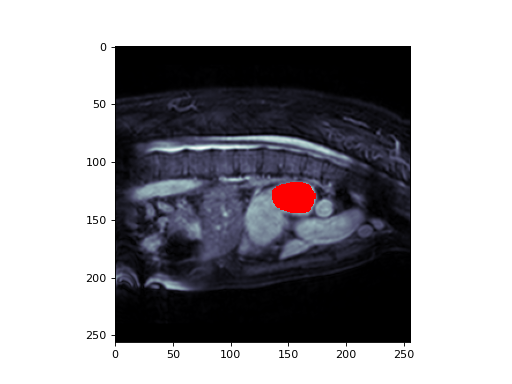

In [26]:
# Plot everything
plt.figure()
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, cmap="autumn")

In [27]:
print(slice.min(), slice.max())

0.0 0.9855595667870035
